## Energy-Based Model, with Hamiltonian Monte Carlo and temperature


In [1]:
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# from matplotlib import rcParams

# %matplotlib inline

# # figure size in inches optional
# rcParams['figure.figsize'] = 11, 8

# # read images
# img_A = mpimg.imread('./ebm/groundtruth.png')
# img_B = mpimg.imread('./ebm/corrupted.png')

# # display images
# fig, ax = plt.subplots(1, 2)
# ax[0].imshow(img_A)
# ax[1].imshow(img_B)

### Tips

+ Training with naive contrastive-divergence algorithm will make your model diverge quickly (think about why). Therefore, you need to add a L2 regularization term $\alpha(E_\theta(x+)^2 + E_\theta(x-)^2)$ to stabilize training.

+ Keep track of the generated samples during training to get a sense of how well your model is evolving.

+ You can take a look at the paper [Implicit Generation and Generalization in Energy Based Models](https://arxiv.org/pdf/1903.08689.pdf) to learn more about useful tricks to get your model working.

+ Make sure your code runs fine with the evaluation cell in this notebook.

## Set Up Code

If you use Colab in this coding project, please uncomment the code, fill the `GOOGLE_DRIVE_PATH_AFTER_MYDRIVE` and run the following cells to mount your Google drive. Then, the notebook can find the required file (i.e., utils.py). If you run the notebook locally, you can skip the following cells.

In [2]:
%load_ext autoreload
%autoreload 2

# from google.colab import drive
# drive.mount('/content/drive')

# import sys
# sys.path.append(GOOGLE_DRIVE_PATH)

In [5]:
from utils import hello
hello()

Good luck!


In [6]:
from collections import deque
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from tqdm.autonotebook import tqdm

import numpy as np
import os
import time
import torch
import torch.nn as nn
import torchvision

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

from utils import save_model, load_model, corruption, train_set, val_set

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device(
    "cuda:1") if torch.cuda.is_available() else torch.device("cpu")

os.makedirs('./ebm', exist_ok=True)

## MLP Model

We have provided an example MLP implementation. Feel free to modify the following cell the implement your own model.

**Note that your model should be an MLP!**

In [7]:
# class MlpBackbone(nn.Module):
#     def __init__(self, input_shape, hidden_size, activation=nn.functional.elu):
#         super(MlpBackbone, self).__init__()
#         self.input_shape = input_shape  # (C, H, W)
#         self.hidden_size = hidden_size
#         # Layers
#         self.fc1 = nn.Linear(np.prod(self.input_shape), self.hidden_size)
#         self.bn1 = nn.BatchNorm1d(self.hidden_size)  # BatchNorm layer
#         self.fc2 = nn.Linear(self.hidden_size, self.hidden_size)
#         self.bn2 = nn.BatchNorm1d(self.hidden_size)  # BatchNorm layer
#         self.fc3 = nn.Linear(self.hidden_size, self.hidden_size)
#         self.bn3 = nn.BatchNorm1d(self.hidden_size)  # BatchNorm layer
#         self.fc4 = nn.Linear(self.hidden_size, 1)

#         self.activation = activation

#     def forward(self, x):
#         x = torch.flatten(x, start_dim=1)
#         x = self.activation(self.bn1(self.fc1(x)))  # Apply BatchNorm after the first linear layer
#         x = self.activation(self.bn2(self.fc2(x)))  # Apply BatchNorm after the second linear layer
#         x = self.activation(self.bn3(self.fc3(x)))  # Apply BatchNorm after the third linear layer
#         out = torch.tanh(self.fc4(x))  # Apply tanh activation to the last linear layer
#         return out

# class MlpBackbone(nn.Module):
#     def __init__(self, input_shape, hidden_size, activation=nn.functional.elu):
#         super(MlpBackbone, self).__init__()
#         self.input_shape = input_shape  # (C, H, W)
#         self.hidden_size = hidden_size
#         # Layers
#         self.conv1 = nn.Conv2d(input_shape[0], 16, kernel_size=3, stride=1, padding=1)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
#         self.fc1 = nn.Linear(32 * input_shape[1] * input_shape[2], self.hidden_size)
#         self.bn1 = nn.BatchNorm1d(self.hidden_size)  # BatchNorm layer
#         self.fc2 = nn.Linear(self.hidden_size, self.hidden_size)
#         self.bn2 = nn.BatchNorm1d(self.hidden_size)  # BatchNorm layer
#         self.fc3 = nn.Linear(self.hidden_size, self.hidden_size)
#         self.bn3 = nn.BatchNorm1d(self.hidden_size)  # BatchNorm layer
#         self.fc4 = nn.Linear(self.hidden_size, 1)

#         self.activation = activation

#     def forward(self, x):
#         x = self.activation(self.conv1(x))
#         x = self.activation(self.conv2(x))
#         x = x.view(x.size(0), -1)  # Flatten the tensor
#         x = self.activation(self.bn1(self.fc1(x)))  # Apply BatchNorm after the first linear layer
#         x = self.activation(self.bn2(self.fc2(x)))  # Apply BatchNorm after the second linear layer
#         x = self.activation(self.bn3(self.fc3(x)))  # Apply BatchNorm after the third linear layer
#         out = torch.tanh(self.fc4(x))  # Apply tanh activation to the last linear layer
#         return out
    
# class MlpBackbone(nn.Module):
#     def __init__(self, input_shape, hidden_size, activation=nn.functional.elu):
#         super(MlpBackbone, self).__init__()
#         self.input_shape = input_shape  # (C, H, W)
#         self.hidden_size = hidden_size
#         # Layers
#         self.conv1 = nn.Conv2d(input_shape[0], 16, kernel_size=3, stride=1, padding=1)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
#         self.resnet = torchvision.models.resnet18(pretrained=False)
#         self.fc1 = nn.Linear(512, self.hidden_size)
#         self.bn1 = nn.BatchNorm1d(self.hidden_size)  # BatchNorm layer
#         self.fc2 = nn.Linear(self.hidden_size, self.hidden_size)
#         self.bn2 = nn.BatchNorm1d(self.hidden_size)  # BatchNorm layer
#         self.fc3 = nn.Linear(self.hidden_size, self.hidden_size)
#         self.bn3 = nn.BatchNorm1d(self.hidden_size)  # BatchNorm layer
#         self.fc4 = nn.Linear(self.hidden_size, 1)

#         self.activation = activation

#     def forward(self, x):
#         x = self.activation(self.conv1(x))
#         x = self.activation(self.conv2(x))
#         x = x.view(x.size(0), -1)  # Flatten the tensor
#         x = self.resnet(x)
#         x = self.activation(self.bn1(self.fc1(x)))  # Apply BatchNorm after the first linear layer
#         x = self.activation(self.bn2(self.fc2(x)))  # Apply BatchNorm after the second linear layer
#         x = self.activation(self.bn3(self.fc3(x)))  # Apply BatchNorm after the third linear layer
#         out = torch.tanh(self.fc4(x))  # Apply tanh activation to the last linear layer
#         return out
    
def Swish(x):
    return x * torch.sigmoid(x)

class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(conv_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)


    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        return out


class ResNetBlock(nn.Module):
    def __init__(self, in_channels, reshape):
        super(ResNetBlock, self).__init__()
        out_channels = in_channels * 2 if reshape else in_channels
        stride = 2 if reshape else 1
        self.conv_block = conv_block(in_channels, out_channels, stride=stride)
        self.relu = nn.ReLU(inplace=True)
        if reshape:
            self.residual_transform = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2)
        else:
            self.residual_transform = None

    def forward(self, x):
        residual = x
        out = self.conv_block(x)
        if self.residual_transform is not None:
            residual = self.residual_transform(residual)
        out = out + residual
        out = self.relu(out)
        return out


class MlpBackbone(nn.Module):
    def __init__(self, input_shape, hidden_size, activation=nn.functional.elu):
        super(MlpBackbone, self).__init__()
        self.input_shape = input_shape  # (C, H, W)
        self.hidden_size = hidden_size
        # Layers
        self.conv1 = nn.Conv2d(input_shape[0], 8, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(8)  # BatchNorm layer
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)  # BatchNorm layer
        self.avgpool = nn.AvgPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)  # BatchNorm layer
        self.resnet1 = ResNetBlock(64, reshape=False)
        self.resnet2 = ResNetBlock(64, reshape=False)
        self.resnet3 = ResNetBlock(64, reshape=False)
        self.fc1 = nn.Linear(64 * 14 * 14, self.hidden_size)
        self.bn4 = nn.BatchNorm1d(self.hidden_size)  # BatchNorm layer
        self.fc2 = nn.Linear(self.hidden_size, 1)
        # self.bn5 = nn.BatchNorm1d(self.hidden_size)  # BatchNorm layer
        # self.fc3 = nn.Linear(self.hidden_size, self.hidden_size)
        # self.bn6 = nn.BatchNorm1d(self.hidden_size)  # BatchNorm layer
        # self.fc4 = nn.Linear(self.hidden_size, 1)

        self.activation = activation

    def forward(self, x):
        x = Swish(self.conv1(x))
        x = Swish(self.conv2(x))
        x = self.avgpool(x)
        x = Swish(self.conv3(x))
        x = self.resnet1(x)
        x = self.resnet2(x)
        x = self.resnet3(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = Swish(self.fc1(x))
        out = self.fc2(x)
        return out



## Sampling

Implement Langevin dynamics in the following cell. Pay attention to the gradients of both your energy model and input.

In [8]:
def langevin_step(energy_model, x, step_lr, eps, max_grad_norm):
    """
    Perform one step of Langevin dynamics sampling.

    Args:
        energy_model (nn.Module): The energy-based model used for sampling.
        x (torch.Tensor): The input tensor to update via Langevin dynamics.
        step_lr (float): The learning rate of the optimizer used to update the input.
        eps (float): The step size of the Langevin dynamics update.
        max_grad_norm (float or None): The maximum norm of the gradient for gradient clipping.

    Returns:
        torch.Tensor: The updated input tensor after one step of Langevin dynamics.
    """
    y = x.clone().detach()
    y.requires_grad = True

    energy = energy_model(y)
    energy.sum().backward()

    gradient = y.grad

    # 添加高斯噪声
    # noise = 0
    noise = torch.randn_like(x) * torch.sqrt(torch.tensor(eps).to(x.device))

    # 如果提供了max_grad_norm，就裁剪梯度
    # if max_grad_norm is not None:
    #     gradient = gradient.clamp(-max_grad_norm, max_grad_norm)

    # 更新x_new
    x_new = x - step_lr * gradient + noise
    x_new = torch.clamp(x_new, 0, 1)  # Ensure pixel values are between 0 and 1

    return x_new


In [9]:
def test() :
    x = torch.randn(256, 1, 28, 28)
    # print(x)
    model = MlpBackbone((1, 28, 28), 1024)
    print("energy:" ,model(x).sum().item())
    for i in range(60):
        x = langevin_step(model, x, 0.002, 0.01, 0.03)
        # print(x)
        print("energy:" ,model(x).sum().item())

# test()

## Inpainting

Implement the inpainting procedure. Think about the difference between sampling and inpainting.

In [10]:
def inpainting(energy_model, x, mask, n_steps, step_lr, max_grad_norm):
    """
    Inpainting function that completes an image given a masked input using Langevin dynamics.

    Args:
        energy_model (nn.Module): The energy-based model used to generate the image.
        x (torch.Tensor): The input tensor, a masked image that needs to be completed.
        mask (torch.Tensor): The mask tensor, with the same shape as x, where 1 indicates the corresponding
                             pixel is visible and 0 indicates it is missing.
        n_steps (int): The number of steps of Langevin dynamics to run.
        step_lr (float): The step size of Langevin dynamics.
        max_grad_norm (float or None): The maximum gradient norm to be used for gradient clipping. If None, 
                                       no gradient clipping is performed.

    Returns:
        torch.Tensor: The completed image tensor.
    """
    reverse_mask = 1-mask


    for _ in range(n_steps):
        out = x.clone().detach()
        out.requires_grad = True
        energy = energy_model(out)
        energy.sum().backward()
        gradient = out.grad
        if max_grad_norm is not None:
            gradient = gradient.clamp(-max_grad_norm, max_grad_norm)
        noise = 0
        # noise = torch.randn_like(x) * torch.sqrt(torch.tensor(2*step_lr).to(x.device)) * reverse_mask
        x = x - step_lr * gradient * reverse_mask + noise
        x = torch.clamp(x, 0, 1)  # Ensure pixel values are between 0 and 1


    return x


In [11]:
def evaluate(energy_model, val_loader, n_sample_steps, step_lr, langevin_grad_norm, 
             device='cuda:1'):
    """
    Evaluates the energy model on the validation set and returns the corruption MSE,
    recovered MSE, corrupted images, and recovered images for visualization.

    Args:
        energy_model (nn.Module): Trained energy-based model.
        val_loader (torch.utils.data.DataLoader): Validation data loader.
        n_sample_steps (int): Number of Langevin dynamics steps to take when sampling.
        step_lr (float): Learning rate to use during Langevin dynamics.
        langevin_grad_norm (float): Maximum L2 norm of the Langevin dynamics gradient.
        device (str): Device to use (default='cuda').
    """
    mse = corruption_mse = 0
    energy_before_sampling = energy_after_sampling = 0
    n_batches = 0
    energy_model.eval()

    pbar = tqdm(total=len(val_loader.dataset))
    pbar.set_description('Eval')
    for data, _ in val_loader:
        n_batches += data.shape[0]
        data = data.to(device)
        broken_data, mask = corruption(data, type_='ebm')
        energy_before_sampling += energy_model(broken_data).sum().item()
        recovered_img = inpainting(energy_model, broken_data, mask,
                                   n_sample_steps, step_lr, langevin_grad_norm)
        energy_after_sampling += energy_model(recovered_img).sum().item()

        mse += np.mean((data.detach().cpu().numpy().reshape(-1, 28 * 28) - recovered_img.detach().cpu().numpy().reshape(-1, 28 * 28)) ** 2, -1).sum().item()
        corruption_mse += np.mean((data.detach().cpu().numpy().reshape(-1, 28 * 28) - broken_data.detach().cpu().numpy().reshape(-1, 28 * 28)) ** 2, -1).sum().item()

        pbar.update(data.shape[0])
        pbar.set_description('Corruption MSE: {:.6f}, Recovered MSE: {:.6f}, Energy Before Sampling: {:.6f}, Energy After Sampling: {:.6f}'.format(
            corruption_mse / n_batches, mse / n_batches, energy_before_sampling / n_batches, energy_after_sampling / n_batches))

    pbar.close()
    return (corruption_mse / n_batches, mse / n_batches, data[:100].detach().cpu(), broken_data[:100].detach().cpu(), recovered_img[:100].detach().cpu())

## Training
Fill the missing parts in the `train` function. There are some comments implying what to do in the corresponding blocks.

In [12]:
import random
import matplotlib.pyplot as plt

def train(n_epochs, energy_model, train_loader, val_loader, optimizer, n_sample_steps, step_lr, langevin_eps, 
          langevin_grad_norm, l2_alpha,
          device='cuda:1', buffer_maxsize=int(1e4), replay_ratio=0.95, save_interval=1, delta=300):
    energy_model.to(device)
    buffer_maxsize = int(1e4)
    buffer_size = buffer_ptr = 0
    replay_buffer = torch.zeros(buffer_maxsize, 1, 28, 28)
    buffer_size = buffer_ptr = 0
    best_mse = np.inf

    def show_replay_buffer() :
        for i in range(2):
            idx = np.random.randint(0, buffer_size)
            print(replay_buffer[idx])
            plt.imshow(replay_buffer[idx].squeeze().cpu().numpy(), cmap='gray')
            plt.show()

    for epoch in range(n_epochs):
        train_loss = energy_before = energy_plus = energy_minus = n_batches = 0
        pbar = tqdm(total=len(train_loader.dataset))
        pbar.set_description('Train')
        for i, (x_plus, _) in enumerate(train_loader):
            n_batches += x_plus.shape[0]
            bs = x_plus.shape[0]
            # print("x_plus shape: ", x_plus.shape)
            # x_plus shape:  torch.Size([256, 1, 28, 28])

            # init negative samples
            if buffer_size == 0:
                x_minus = torch.rand_like(x_plus)
            else:
                ##############################################################################


                x_minus = torch.zeros_like(x_plus)

                for j in range(bs):
                    p = random.random()
                    if (p < replay_ratio): # This can be changed
                    # Sample a random index from the replay buffer
                        idx = np.random.randint(0, buffer_size)
                    # Get the corresponding sample from the replay buffer
                        x_minus[j] = replay_buffer[idx]
                    else :
                        x_minus[j] = torch.rand_like(x_plus[j])
                
                ##############################################################################

            x_minus = x_minus.to(device)
            # print("x_minus shape: ", x_minus.shape)

            energy_before += energy_model(x_minus).sum().item()

            # sample negative samples
            ##############################################################################

            for stepsss in range(n_sample_steps):
                x_minus = langevin_step(energy_model, x_minus, step_lr, langevin_eps, langevin_grad_norm)

            ##############################################################################

            # extend buffer
            if buffer_ptr + bs <= buffer_maxsize:
                replay_buffer[buffer_ptr: buffer_ptr +
                              bs] = ((x_minus * 255).to(torch.uint8).float() / 255).cpu()
            else:
                x_minus_ = (
                    (x_minus * 255).to(torch.uint8).float() / 255).cpu()
                replay_buffer[buffer_ptr:] = x_minus_[
                    :buffer_maxsize - buffer_ptr]
                remaining = bs - (buffer_maxsize - buffer_ptr)
                replay_buffer[:remaining] = x_minus_[
                    buffer_maxsize - buffer_ptr:]
            buffer_ptr = (buffer_ptr + bs) % buffer_maxsize
            buffer_size = min(buffer_maxsize, buffer_size + bs)

            # compute loss
            energy_model.train()
            x_plus = x_plus.to(device)
            x_minus = x_minus.to(device)
            e_plus = energy_model(x_plus)
            e_minus = energy_model(x_minus)
            ##############################################################################


            # loss = e_plus + torch.clamp(delta - e_minus, min=0) 
            loss = e_plus - e_minus
            # add a term: l2alpha times e_plus ^ 2 + e_minus ^ 2
            # e_plus = torch.clamp(e_plus, -0.999, 0.999)
            # e_minus = torch.clamp(e_minus, -0.999, 0.999)
            l2_loss = l2_alpha * (e_plus ** 2 + e_minus ** 2).mean()
            loss_mean = loss.mean()
            loss_mean += l2_loss
            optimizer.zero_grad()
            loss_mean.backward()
            torch.nn.utils.clip_grad_norm_(energy_model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()

            ##############################################################################

            train_loss += loss.sum().item()
            energy_plus += e_plus.sum().item()
            energy_minus += e_minus.sum().item()

            pbar.update(x_plus.size(0))
            pbar.set_description("Train Epoch {}, Train Loss: {:.6f}, ".format(epoch + 1, train_loss / n_batches) +
                                 "Energy Before Sampling: {:.6f}, ".format(energy_before / n_batches) +
                                 "Energy After Sampling: {:.6f}, ".format(energy_minus / n_batches) +
                                 "Energy of Ground Truth: {:.6f}".format(energy_plus / n_batches))
        pbar.close()
        show_replay_buffer()

        if (epoch + 1) % save_interval == 0:
            os.makedirs(f'./ebm/{epoch + 1}', exist_ok=True)
            energy_model.eval()
            save_model(f'./ebm/{epoch + 1}/ebm.pth',
                       energy_model, optimizer, replay_buffer)

            # evaluate inpaiting
            # feel free to change the inpainting parameters!
            c_mse, r_mse, original, broken, recovered = evaluate(energy_model, val_loader,
                                                                 100, 5, 0.1, device=device)
            torchvision.utils.save_image(
                original, f"./ebm/{epoch + 1}/groundtruth.png", nrow=10)
            torchvision.utils.save_image(
                broken, f"./ebm/{epoch + 1}/corrupted.png", nrow=10)
            torchvision.utils.save_image(
                recovered, f"./ebm/{epoch + 1}/recovered.png", nrow=10)
            if r_mse < best_mse:
                print(f'Current best MSE: {best_mse} -> {r_mse}')
                best_mse = r_mse
                save_model('./ebm/ebm_best.pth', energy_model)

In [13]:
model = MlpBackbone((1, 28, 28), 1024).to(device)
# for param in model.parameters():
#     if param.dim() > 1:
#         nn.init.orthogonal_(param)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.0, 0.999))

train_loader = DataLoader(train_set, 256, shuffle=True, drop_last=False, pin_memory=True)
val_loader = DataLoader(val_set, 500, shuffle=True, drop_last=False, pin_memory=True)

Now you can start your training. Please keep in mind that this cell may **NOT** be run when we evaluate your assignment!

In [14]:
def show_mnist() :
    for data, _ in val_loader:
        x = data[0]
        broken_data, mask = corruption(x, type_='ebm')
        print(broken_data)
        print(mask)
        # show the image
        plt.imshow(broken_data[0].squeeze().cpu().numpy(), cmap='gray')
        break
# show_mnist()

  0%|          | 0/60000 [00:00<?, ?it/s]

tensor([[[0.0196, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0157, 0.0000, 0.0196, 0.0000, 0.0000, 0.0000, 0.0000, 0.0510,
          0.0000, 0.0000, 0.0784, 0.0118, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0039, 0.0000, 0.1020],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0314],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0078, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0235, 0.0000, 0.0000, 0.0000, 0.0000, 0.0471,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.1059, 0.0000, 0.0510, 0.0196, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

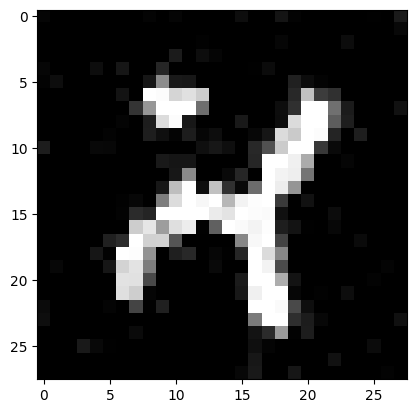

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0431, 0.0314, 0.0000, 0.0000, 0.0000, 0.0314, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0196, 0.0745, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0157, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0431, 0.0431,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0275,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0275, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0118, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0471,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

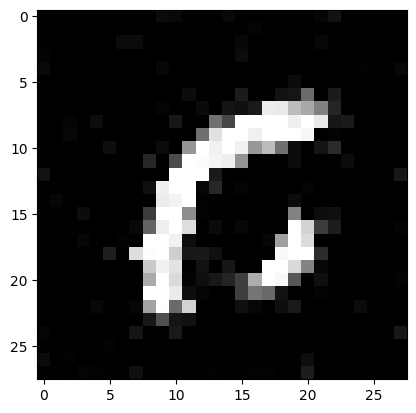

  0%|          | 0/10000 [00:00<?, ?it/s]

Current best MSE: inf -> 0.01379554567337036


  0%|          | 0/60000 [00:00<?, ?it/s]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0510, 0.0000, 0.0549, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0353, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0235, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0549, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

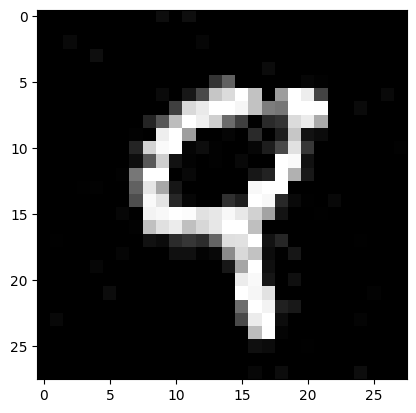

tensor([[[0.0392, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0157, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0235, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0157, 0.0510],
         [0.0000, 0.0000, 0.0000, 0.0078, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0824, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0392, 0.0000, 0.0000, 0.0353, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0314, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0941],
         [0.0000, 0.0627, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0157, 0.0000, 0.0000,

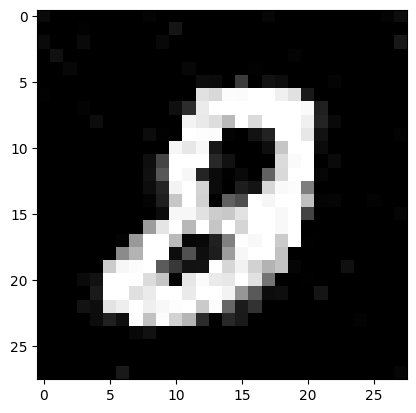

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

tensor([[[0.0000, 0.0000, 0.0784, 0.0000, 0.0000, 0.0314, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0510, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0118, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0314, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0745, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

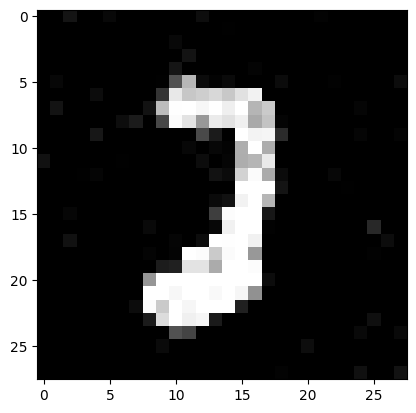

tensor([[[0.0000, 0.0549, 0.0000, 0.0000, 0.0745, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0118, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

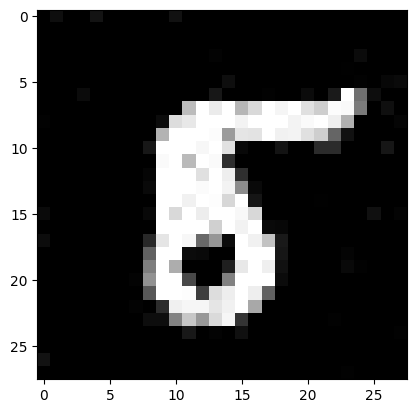

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0510, 0.0000, 0.0078, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0510, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0039, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0627, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0078, 0.0824],
         [0.0000, 0.0000, 0.1176, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0157, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0118, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0039, 0.0000, 0.0000, 0.0000, 0.0000,

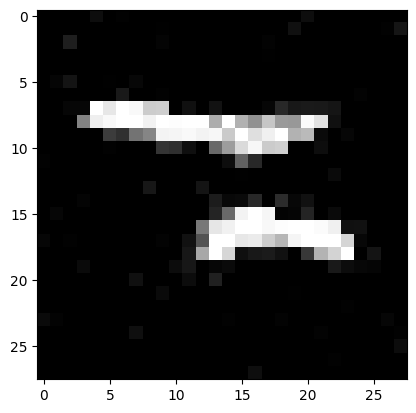

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0353, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0118, 0.0000, 0.0000, 0.0000, 0.0157, 0.0745,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0196, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0353, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.1098, 0.1843, 0.0000, 0.0000, 0.0000, 0.0000,

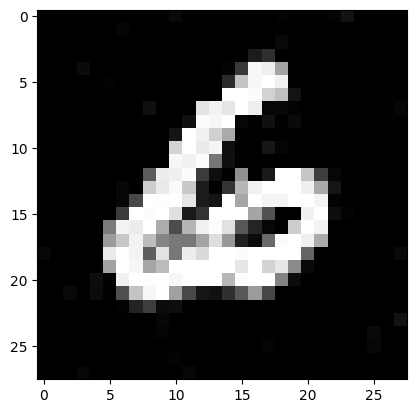

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0118, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0118, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0078, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0118,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

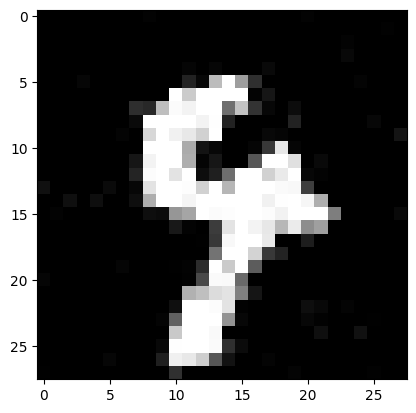

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1176,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0000, 0.0000, 0.0000, 0.0431, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0118, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

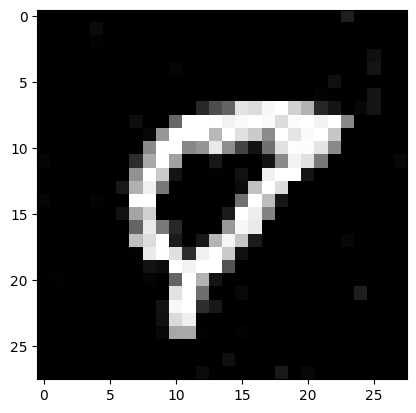

  0%|          | 0/10000 [00:00<?, ?it/s]

Current best MSE: 0.01379554567337036 -> 0.01215599536895752


  0%|          | 0/60000 [00:00<?, ?it/s]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0745, 0.0000,
          0.0000, 0.0157, 0.0706, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0941, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0745, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0196, 0.0000, 0.0000, 0.0902, 0.0118, 0.0039, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.1961, 0.8392, 1.0000, 0.4471,
          0.1608, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0157, 0.2510, 0.5255, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.8745,

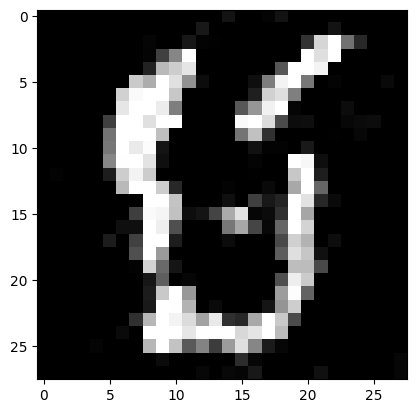

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0510,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0549, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0353, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0588, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0353, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0980, 0.0000, 0.0000, 0.0000, 0.0000, 0.0627, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

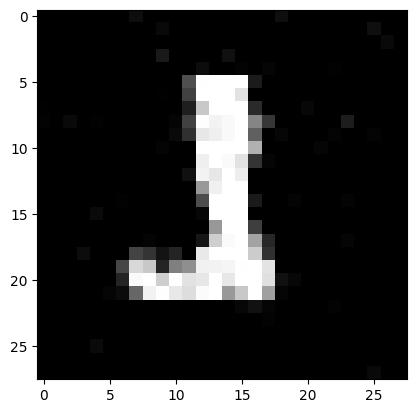

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

tensor([[[0.0000, 0.0118, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0118, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0196, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0510, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

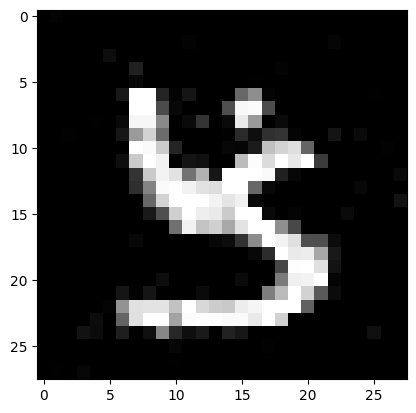

tensor([[[0.0000, 0.0000, 0.0000, 0.0745, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0863],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0118, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0275, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0275, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0902],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0706, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

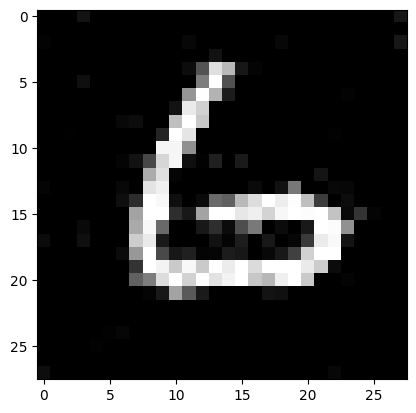

  0%|          | 0/10000 [00:00<?, ?it/s]

Current best MSE: 0.01215599536895752 -> 0.011135395002365113


  0%|          | 0/60000 [00:00<?, ?it/s]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0235, 0.0824, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0118, 0.0000, 0.0000, 0.0000, 0.0784, 0.0000, 0.0000, 0.0000,
          0.0314, 0.0471, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0157, 0.0000, 0.0314, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0118,
          0.0000, 0.0745, 0.0000, 0.0000, 0.0627, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0824, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0157,
          0.5020, 0.7412, 0.9176, 0.9922, 0.8235, 0.3686,

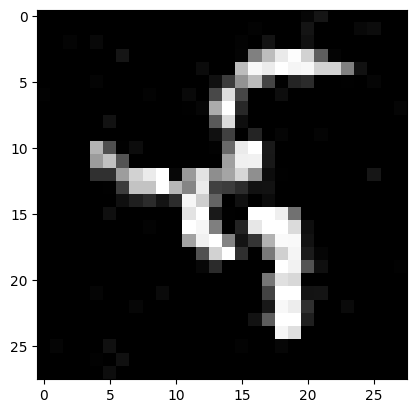

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0078, 0.0000, 0.0863,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0078, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0196, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0588, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

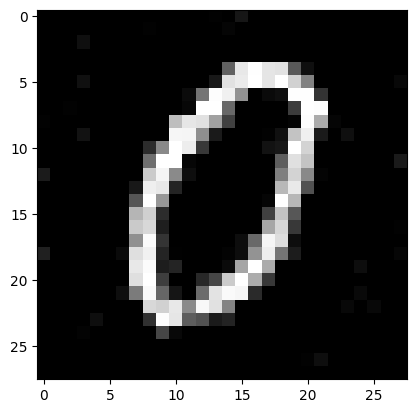

  0%|          | 0/10000 [00:00<?, ?it/s]

Current best MSE: 0.011135395002365113 -> 0.008973808288574218


  0%|          | 0/60000 [00:00<?, ?it/s]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0118, 0.0000, 0.0000, 0.0627, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0078, 0.0000,

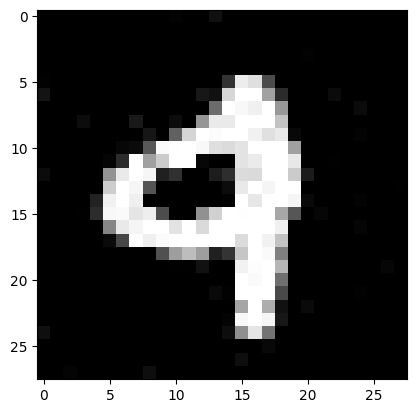

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0118, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0667, 0.0000, 0.0000, 0.0235, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0235],
         [0.0235, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

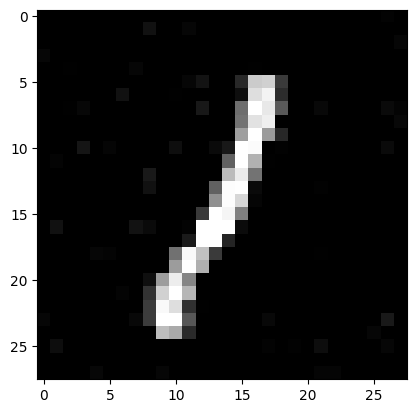

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0275, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0196,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0196, 0.0000, 0.0000, 0.0588, 0.0706, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

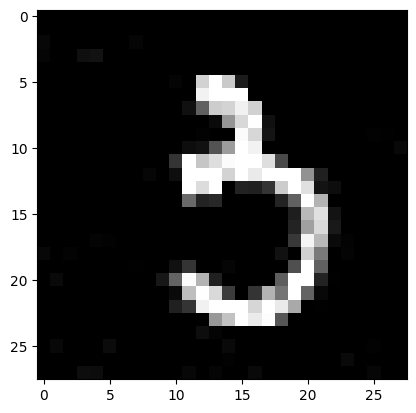

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0118,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0314, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0431,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0039, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0471, 0.0000, 0.0000, 0.0078, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0471, 0.0000, 0.0000, 0.0000, 0.0000,

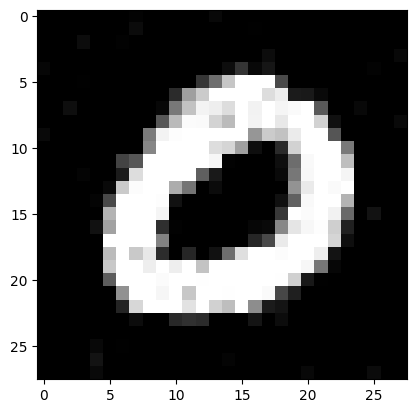

  0%|          | 0/10000 [00:00<?, ?it/s]

In [15]:
# feel free the change training hyper-parameters!
n_sample_steps = 100
step_lr = 10
eps = 0.005
langevin_grad_norm = 0.3
l2_alpha = 0.01
replay_ratio = 0.95
train(10, model, train_loader, val_loader, optimizer, n_sample_steps=n_sample_steps, step_lr=step_lr, 
      langevin_eps=eps, langevin_grad_norm=langevin_grad_norm, l2_alpha=l2_alpha, device=device, 
      replay_ratio=replay_ratio)


# n_sample_steps, step_lr, langevin_eps, langevin_grad_norm, l2_alpha

In [16]:
import matplotlib.pyplot as plt

def show_recover(device = "cuda:1") :
    for data, _ in val_loader:
        x = data[0]
        x = x.to(device)
        broken_data, mask = corruption(x, type_='ebm')
        # print(broken_data)
        # show the energy of broken_data, first resize the broken_data to (1, 1, 28, 28)
        broken_data = broken_data.unsqueeze(0)
        
        # Calculate the energy of the broken_data using the energy_model
        model.eval()
        energy = model(broken_data)
        print("Energy of broken_data:", energy.item())

        # Perform inpainting on the broken_data
        recovered_img = inpainting(model, broken_data, mask, 500, 0.05, langevin_grad_norm)
        print(recovered_img - broken_data)
        # show the energy of recovered_img
        recovered_img = recovered_img.squeeze(0)
        recovered_img = recovered_img.unsqueeze(0)
        energy = model(recovered_img)
        print("Energy of recovered_img:", energy.item())
        # show the recovered image and the corrupted image
        plt.imshow(recovered_img.squeeze().cpu().numpy(), cmap='gray')
        plt.show()
        plt.imshow(broken_data.squeeze().cpu().numpy(), cmap='gray')

        # show the image
        # plt.imshow(broken_data[0].squeeze().cpu().numpy(), cmap='gray')
        break
# show_recover()

## Evaluation

Make sure you can run the following evaluation cell.

In [17]:
# feel free to change evaluation parameters!
# inpainting parameters are not necessarily the same as sampling parameters
n_sample_steps = 100
step_lr = 5
langevin_grad_norm = 0.03

In [18]:

model.load_state_dict(load_model('./ebm/ebm_best.pth')[0])
corruption_mse, mse, original, broken, recovered = evaluate(model, val_loader, n_sample_steps, step_lr, langevin_grad_norm, device=device)
os.makedirs(f'./ebm/eval', exist_ok=True)

torchvision.utils.save_image(
                original, f"./ebm/eval/groundtruth.png", nrow=10)
torchvision.utils.save_image(
                broken, f"./ebm/eval/corrupted.png", nrow=10)
torchvision.utils.save_image(
                recovered, f"./ebm/eval/recovered.png", nrow=10)


print(f'Corruption MSE: {corruption_mse}')
print(f'Recovered MSE: {mse}')


  0%|          | 0/10000 [00:00<?, ?it/s]

Corruption MSE: 0.06345630607604981
Recovered MSE: 0.00898576021194458
